In [18]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism
import numpy as np
import matplotlib
import hashlib
from random import randint, choice
import igraph as ig

# these files are created using hh.ru api
with open('1.json', 'r') as f:
    stations_moscow = json.load(f)['lines']

with open('3.json', 'r') as f:
    stations_nnovgorod = json.load(f)['lines']

In [2]:
def get_adjency_matrix(stations_data):
    # extracting all station names
    station_names = set()
    for line in stations_data:
        line = line['stations']
        for station in line:
            station_names.add(station['name'])
            
    # creating adjacency matrix using pandas
    df = pd.DataFrame(0, index=station_names, columns=station_names)

    # and filling it
    for line in stations_data:
        line = line['stations']
        prev_st = None
        for station in line:
            st_name = station['name']
            # connecting cur station to previous on the same line
            if prev_st is not None:
                df[st_name][prev_st] = 1
                df[prev_st][st_name] = 1
            prev_st = st_name
            
    return df

# functions for extracting coordinates (also saving color for every line)
def get_coordinates(stations_data):
    coordinates = {}
    counter = 0
    for line in stations_data:
        line = line['stations']
        for station in line:
            coordinates[station['name']] = (station['lat'], station['lng'], counter)
        counter += 1

    # scaling
    min_coord_X = min([i[0] for i in coordinates.values()])
    min_coord_Y = min([i[1] for i in coordinates.values()])
    for key, item in dict(coordinates).items():
        coordinates[key] = (item[0] - min_coord_X, item[1] - min_coord_Y, item[2])
        
    max_coord_X = max([i[0] for i in coordinates.values()])
    max_coord_Y = max([i[1] for i in coordinates.values()])
    for key, item in dict(coordinates).items():
        coordinates[key] = (item[0] / max_coord_X, item[1] / max_coord_Y, item[2])
    
    return coordinates

In [3]:
# data and some methods are taken from
# http://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/
lines       = pd.read_csv('london.lines.csv', index_col=0)
stations    = pd.read_csv('london.stations.csv', index_col=0)
connections = pd.read_csv('london.connections.csv')

In [4]:
moscow_df = get_adjency_matrix(stations_moscow)
nnovgorod_df = get_adjency_matrix(stations_nnovgorod)

moscow_crd = get_coordinates(stations_moscow)
nnovgorod_crd = get_coordinates(stations_nnovgorod)

# creating moscow graph
G_moscow = nx.Graph()
G_moscow.add_nodes_from(range(len(moscow_df)))

adjency_matrix = moscow_df.as_matrix()

for idx, i in enumerate(adjency_matrix):
    for jdx, j in enumerate(i):
        if j == 0: continue
        G_moscow.add_edge(idx, jdx)
        

# creating n_novgorod graph
G_nnovgorod = nx.Graph()
G_nnovgorod.add_nodes_from(range(len(nnovgorod_df)))

adjency_matrix = nnovgorod_df.as_matrix()

for idx, i in enumerate(adjency_matrix):
    for jdx, j in enumerate(i):
        if j == 0: continue
        G_nnovgorod.add_edge(idx, jdx)
        
# creating london graph
G_london = nx.Graph()

l_stations_lines = {}
for connection_id, connection in connections.iterrows():
    station1_name = stations.loc[connection['station1']]['name']
    station2_name = stations.loc[connection['station2']]['name']
    l_stations_lines[station1_name] = connection['line']
    l_stations_lines[station2_name] = connection['line']
    G_london.add_edge(station1_name, station2_name)

In [5]:
# we need to truncate london graph to same count of nodes as in Moscow
# but it should still be connected
print (len(G_moscow.nodes()))
print (len(G_london.nodes()))

200
302


In [6]:
while len(G_london.nodes()) != len(G_moscow.nodes()):
    # getting fresh list of nodes
    london_nodes = list(G_london.nodes())
    # choosing random node
    node = choice(london_nodes)
    # saving edges to insert them later if needed
    neighbours = G_london.neighbors(node)
    edges_removed = [(node, i) for i in neighbours]
    # removing node
    G_london.remove_node(node)
    # checking if it is still connected
    if not nx.is_connected(G_london):
        # if not, add node and it edges back and try again with another one
        G_london.add_edges_from(edges_removed)

In [7]:
# ok, now we have equal count of nodes
print (len(G_london.nodes()))

200


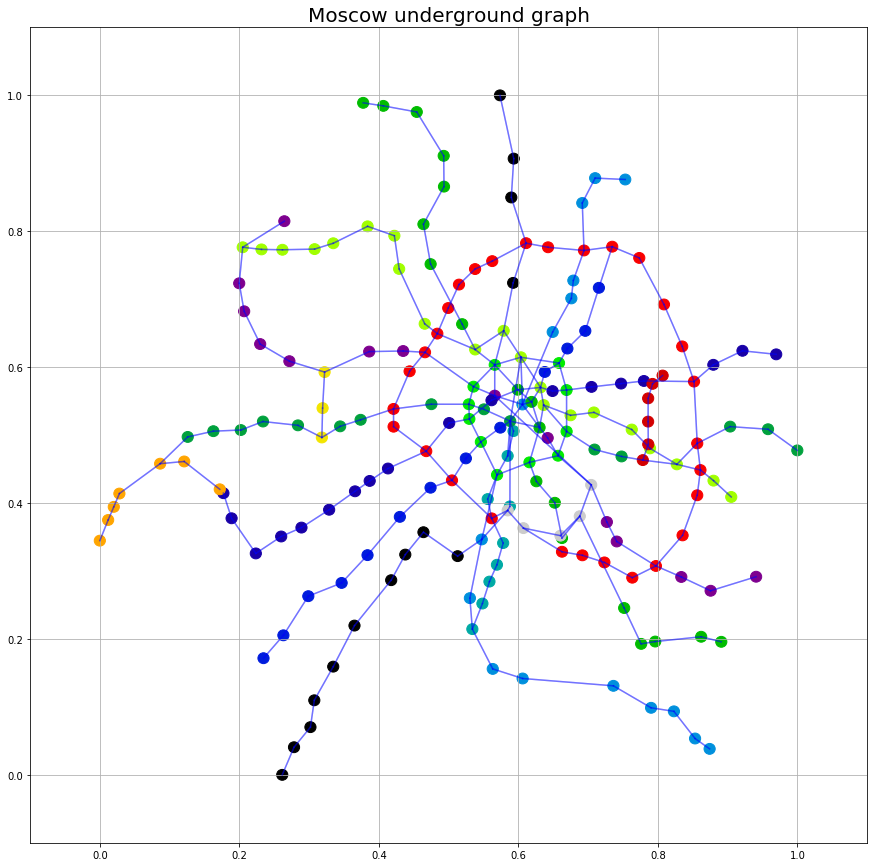

In [8]:
# Lets add some visualization!
cmap = matplotlib.cm.get_cmap('nipy_spectral')

fig = plt.figure(figsize=(15,15))
plt.axis([-0.1,1.1,-0.1,1.1])
ax = plt.gca()

for line in moscow_df.iterrows():
    name = line[0]
    x, y, color = moscow_crd[name]
    for num, i in enumerate(line[1]):
        if i == 1:
            x, y, color = moscow_crd[name]
            x1, y1, color1 = moscow_crd[moscow_df.index[num]]
            plt.plot([x, x1], [y, y1], color='b', alpha=0.33)
    ax.add_artist( plt.Circle((x, y), 0.008, color=cmap(color/14), alpha=1) )
            
plt.title('Moscow underground graph', size=20)
plt.grid()
plt.show()

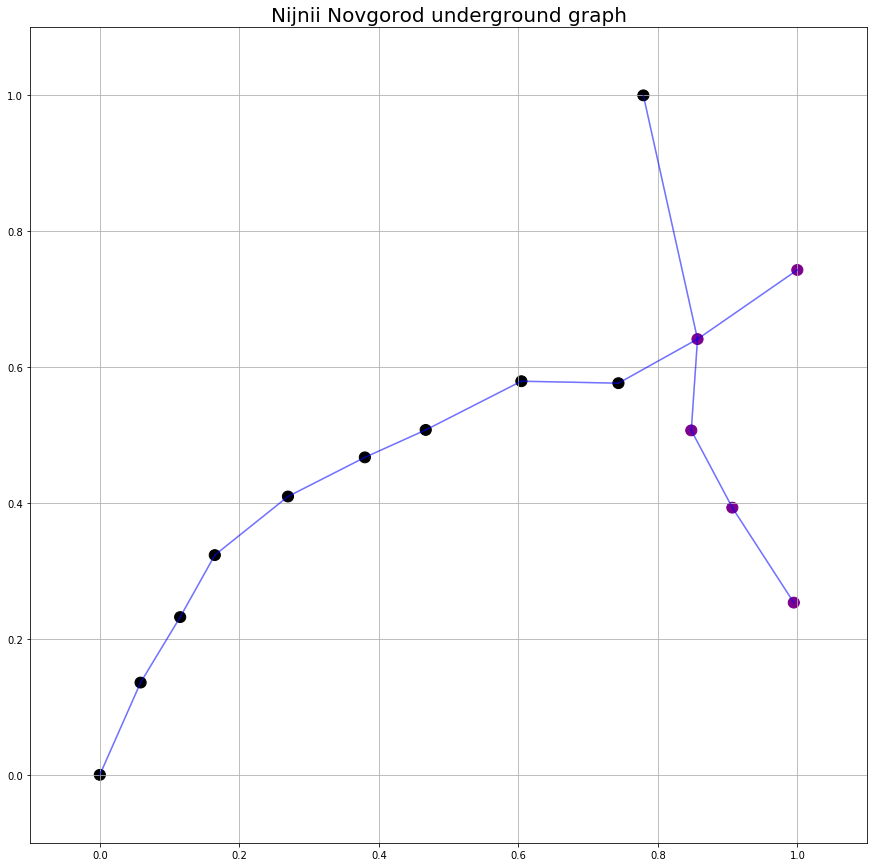

In [9]:
cmap = matplotlib.cm.get_cmap('nipy_spectral')

fig = plt.figure(figsize=(15,15))
plt.axis([-0.1,1.1,-0.1,1.1])
ax = plt.gca()

for line in nnovgorod_df.iterrows():
    name = line[0]
    x, y, color = nnovgorod_crd[name]
    for num, i in enumerate(line[1]):
        if i == 1:
            x, y, color = nnovgorod_crd[name]
            x1, y1, color1 = nnovgorod_crd[nnovgorod_df.index[num]]
            plt.plot([x, x1], [y, y1], color='b', alpha=0.33)
    ax.add_artist( plt.Circle((x, y), 0.008, color=cmap(color/14), alpha=1) )
            
plt.title('Nijnii Novgorod underground graph', size=20)
plt.grid()
plt.show()

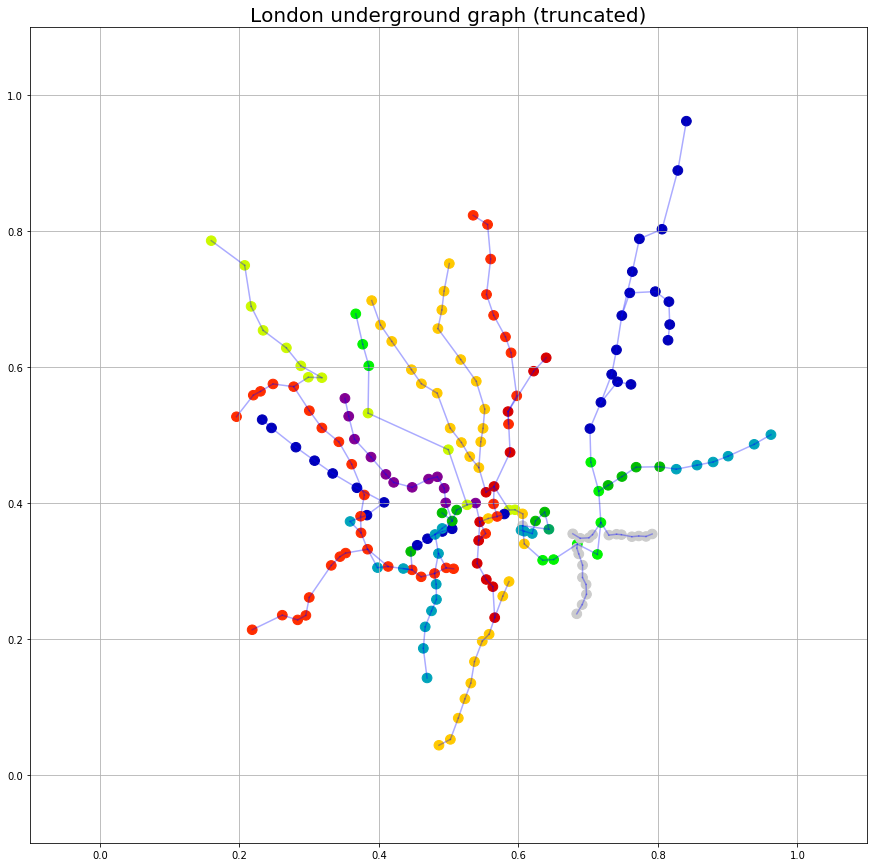

In [10]:
normed = stations[['longitude', 'latitude']]
normed = normed - normed.min()
normed = normed / normed.max()
locations = dict(zip(stations['name'], normed[['longitude', 'latitude']].values))

cmap = matplotlib.cm.get_cmap('nipy_spectral')

fig = plt.figure(figsize=(15,15))
plt.axis([-0.1,1.1,-0.1,1.1])
ax = plt.gca()

for edge in G_london.edges():
    x= [locations[pt][0] for pt in edge]
    y= [locations[pt][1] for pt in edge]
    plt.plot(x, y, color='blue', alpha=0.33)

for node in G_london.nodes():
    x = locations[node][0]
    y = locations[node][1]
    ax.add_artist(plt.Circle(
        (x, y), 
        radius = .007,
        color=cmap(l_stations_lines[node]/12)
    ))
    
plt.title('London underground graph (truncated)', size=20)
plt.grid()
plt.show()

In [36]:
# creating graphs using igrpah library in order to use BLISS algorithm
G2_moscow = ig.Graph()
G2_london = ig.Graph()

G2_london.add_vertices(list(G_london.nodes()))
G2_london.add_edges(list(G_london.edges()))

G2_moscow.add_vertices(list(G_moscow.nodes()))
G2_moscow.add_edges(list(G_moscow.edges()))

In [43]:
GM_1 = isomorphism.GraphMatcher(G_moscow,G_nnovgorod)
GM_2 = isomorphism.GraphMatcher(G_moscow,G_london)

# is there an isomorphic to nNovgorod subgrpah in Moscow?
print (GM_1.subgraph_is_isomorphic())

# is Moscow graph isomorphic to London graph?
# BLISS algorithm
print (G2_moscow.isomorphic_bliss(G2_london))

# is Moscow graph isomorphic to London graph?
# VF2 algorithm
print (GM_2.is_isomorphic())

True
False
False


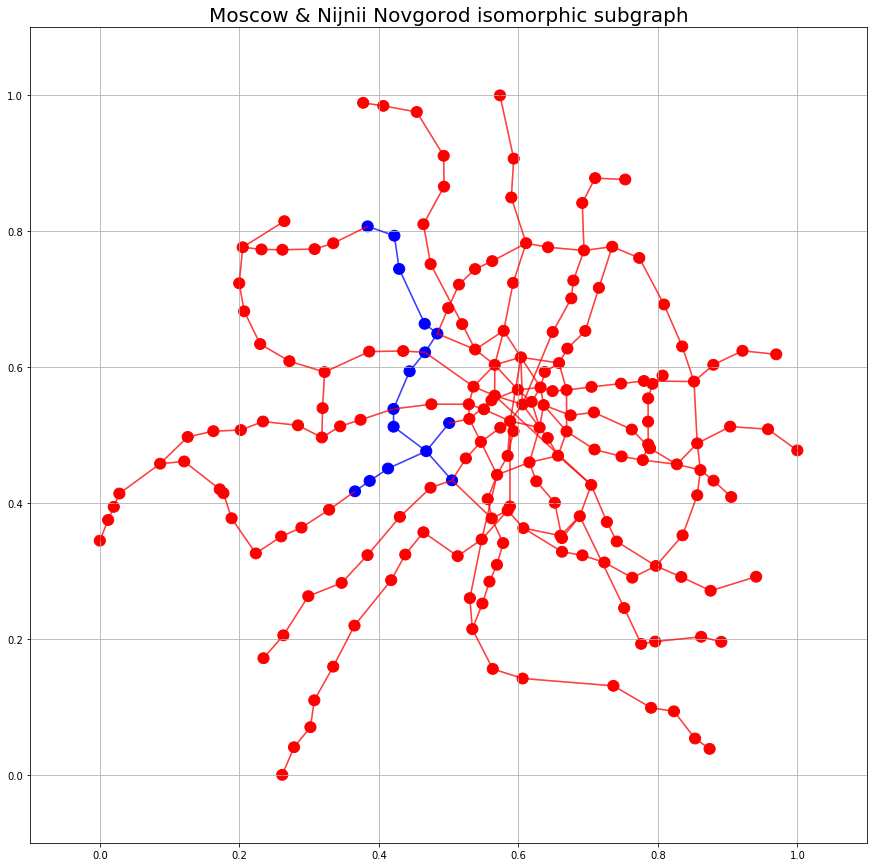

In [15]:
# Lets find isomorphic subgraph in Moscow
cmap = matplotlib.cm.get_cmap('prism')

fig = plt.figure(figsize=(15,15))
plt.axis([-0.1,1.1,-0.1,1.1])
ax = plt.gca()

# getting subgraph permuttation
subgraph = next(GM_1.subgraph_isomorphisms_iter())
subgraph = np.array(list(subgraph.keys()))

for num1, line in enumerate(moscow_df.iterrows()):
    name = line[0]
    x, y, color = moscow_crd[name]
    for num, i in enumerate(line[1]):
        if i == 1:
            x1, y1, color1 = moscow_crd[moscow_df.index[num]]
            clr = 'blue' if num1 in subgraph and num in subgraph else 'red'
            plt.plot([x, x1], [y, y1], color=clr, alpha=0.5)
    clr = 'blue' if num1 in subgraph else 'red'
    ax.add_artist( plt.Circle((x, y), 0.008, color=clr, alpha=1) )
    
            
plt.title('Moscow & Nijnii Novgorod isomorphic subgraph', size=20)
plt.grid()
plt.show()